In [1026]:
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, distance
import cv2
import numpy as np
import matplotlib.cm as cm
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.lines as mlines
import string
import matplotlib.patches as patches

In [1027]:
column_names = ['frame','vehicle_id','vehicle_type','a','b','c','X1','Y1','X2','Y2',]
df = pd.read_csv("C:\\Users\\ancha\\Box\\QC-5900\\Data\\project2\\16393238\\segments\\16393238-cam_1-2-north_west-20231109_0000-010_1699916237331_out\\16393238-cam_1-2-north_west-20231109_0000-010_1699916237331.txt", sep=' ', header=None, usecols = [0,1,2,3,4,5,6,7,8,9], names=column_names)
df['Center_X'] = (df['X1']+df['X2']) / 2
df['Center_Y'] = (df['Y1']+df['Y2']) / 2

df = df[['frame','vehicle_id','vehicle_type','Center_X','Center_Y']]

In [1028]:
print(df.shape)
df_unique = df.nunique()
df_unique

(70276, 5)


frame           30688
vehicle_id       1569
vehicle_type       10
Center_X         1265
Center_Y          650
dtype: int64

In [1029]:
image_path = "C:\\Users\\ancha\\Box\\QC-5900\\Data\\project2\\16393238\\16393238-cam_1-2-north_west-20231109_0000_1699916237331_out\\16393238-cam_1-2-north_west-20231109_0000_1699916237331_frame.jpg"

In [1030]:
df_sorted = df.sort_values(by=['vehicle_id','frame'])
df_sorted = df_sorted.groupby('vehicle_id').filter(lambda x: len(x) >= 15)
df_first_frame = df_sorted.groupby('vehicle_id').head(1).reset_index()
df_last_frame = df_sorted.groupby('vehicle_id').tail(1).reset_index()
df_combined = pd.concat([df_first_frame, df_last_frame]).sort_values(by='vehicle_id').reset_index()

In [1031]:
print(df_first_frame.shape)
print(df_last_frame.shape)

(1222, 6)
(1222, 6)


In [1032]:
# Assume df_first contains the first occurrence of each vehicle with 'x_center' and 'y_center'
# normalize X, Y coordinates
df_first_frame['Center_X_norm'] = (df_first_frame['Center_X'] - df_first_frame['Center_X'].mean()) / df_first_frame['Center_X'].std()
df_first_frame['Center_Y_norm'] = (df_first_frame['Center_Y'] - df_first_frame['Center_Y'].mean()) / df_first_frame['Center_Y'].std()

# Step 1: Extract the coordinates
X_first = df_first_frame[['Center_X_norm', 'Center_Y_norm']].values

# Step 2: Apply DBSCAN
# adjust epsilon ('eps') and min_samples based on data scale.
db = DBSCAN(eps=0.2, min_samples=20)  # eps is the maximum distance between two samples for them to be considered neighbors

# Step 3: Fit the DBSCAN model
df_first_frame['Cluster'] = db.fit_predict(X_first)
df_outlier = df_first_frame[df_first_frame['Cluster'] == -1].reset_index(drop=True)
df_first = df_first_frame[df_first_frame['Cluster'] != -1].reset_index(drop=True)

# Compute centroid of each cluster
centroids = df_first.groupby('Cluster')[['Center_X', 'Center_Y']].mean().reset_index()

# Display centroids
# print(centroids)

# Display no. of vehicles in each cluster
print(df_first['Cluster'].value_counts())
print(df_outlier.shape)



Cluster
0    650
1    375
3     92
4     45
2     39
Name: count, dtype: int64
(21, 9)


In [1033]:
unique_clusters = df_first['Cluster'].unique()
# Create a dynamic mapping from cluster ID to gate name
cluster_to_gate = {cluster_id: f'Gate {i+1}' for i, cluster_id in enumerate(unique_clusters)}
print(cluster_to_gate)
# Assign the corresponding gate names to the 'Gate' column
df_first['InGate'] = df_first['Cluster'].map(cluster_to_gate)

{4: 'Gate 1', 0: 'Gate 2', 1: 'Gate 3', 2: 'Gate 4', 3: 'Gate 5'}


0 : (73.26, 152) : 650
1 : (593.54, 249) : 375
2 : (611.38, 306) : 39
3 : (49.06, 404) : 92
4 : (22.89, 337) : 45
   InClusterId  InGate       Centroid                      Boundary
0            0  Gate 2   (73.26, 152)   (47.5, 121.5, 135.0, 186.0)
1            1  Gate 3  (593.54, 249)  (506.0, 622.5, 213.0, 281.0)
2            2  Gate 4  (611.38, 306)  (579.5, 626.5, 289.0, 333.0)
3            3  Gate 5   (49.06, 404)   (20.0, 102.5, 383.5, 421.0)
4            4  Gate 1   (22.89, 337)    (12.0, 65.0, 311.0, 357.0)


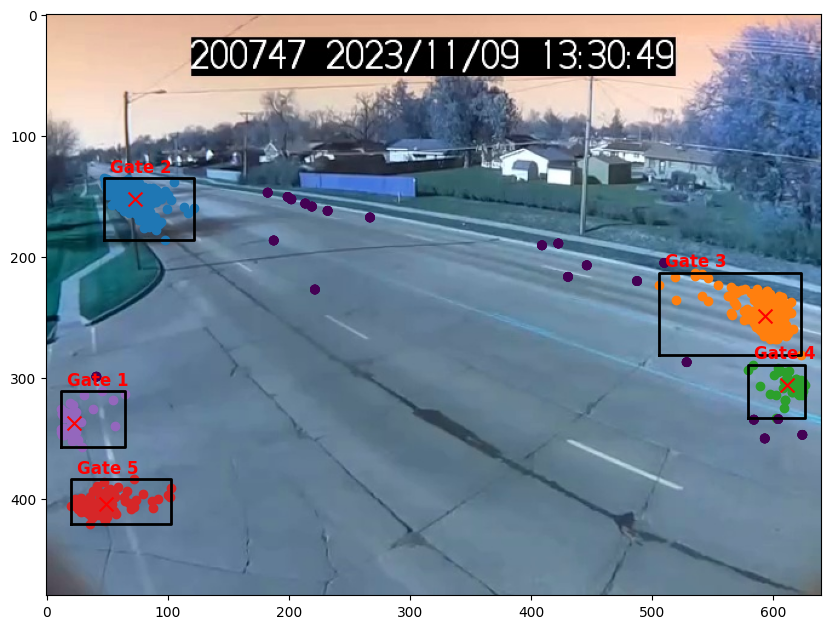

In [1034]:
df_first_clusters = df_first.copy()

# Store updated clusters
updated_clusters = []
fig, ax = plt.subplots(figsize=(10, 8))
for cluster_id, group in df_first_clusters.groupby('Cluster'):
    # centroid = group[['Center_X','Center_Y']].mean().values
    centroid = (round(float(group['Center_X'].mean()),2), round(float(group['Center_Y'].mean())))
    cluster_count = len(group)
    print(cluster_id, ":", centroid, ":", cluster_count)


    # Find the extreme points
    x_min = group.loc[group['Center_X'].idxmin(), 'Center_X']  # Leftmost point
    x_max = group.loc[group['Center_X'].idxmax(), 'Center_X']  # Rightmost point
    y_min = group.loc[group['Center_Y'].idxmin(), 'Center_Y']  # Bottommost point
    y_max = group.loc[group['Center_Y'].idxmax(), 'Center_Y']  # Topmost point
    
    # # Identify outliers that are outside the cluster boundary
    # outliers_outside_boundary = df_outlier[
    #     (df_outlier['Center_X'] < x_min) | (df_outlier['Center_X'] > x_max) |
    #     (df_outlier['Center_Y'] < y_min) | (df_outlier['Center_Y'] > y_max)
    # ]
        
    # Define rectangle boundary
    rectangle_corners = np.array([
        [x_min, y_max],  # Top-left
        [x_max, y_max],  # Top-right
        [x_max, y_min],  # Bottom-right
        [x_min, y_min],  # Bottom-left
        [x_min, y_max]   # Close the rectangle
    ])

    # Plot the rectangle
    plt.plot(rectangle_corners[:, 0], rectangle_corners[:, 1], 'k-', linewidth=2)

    plt.scatter(df_outlier['Center_X'], df_outlier['Center_Y'], c = df_outlier['Cluster'])
    
    # Get InGate value using the cluster_id
    in_gate = cluster_to_gate.get(cluster_id, 'Unknown')  # Default to 'Unknown' if cluster_id not in the mapping

    # Append updated cluster data
    updated_clusters.append({
        'InClusterId': cluster_id,
        'InGate': in_gate,
        'Centroid': (centroid[0], centroid[1]),
        'Boundary': (x_min, x_max, y_min, y_max)
    })

    # Plot cluster points
    plt.scatter(group['Center_X'], group['Center_Y'], label=f'Cluster {cluster_id}')

    # Plot gate name near the cluster boundary (placing near top-right corner)
    plt.text(x_min + 5, y_min - 5, f'{in_gate}', fontsize=12, color='red', fontweight='bold')


    # Plot centroid
    plt.scatter(centroid[0], centroid[1], color='red', marker='x', s=100, label=f'Centroid {cluster_id}')

    ax.imshow(cv2.imread(image_path))

InGateClusters = pd.DataFrame(updated_clusters).sort_values('InClusterId').reset_index(drop=True)
print(InGateClusters)


In [1035]:
# Assume df_last contains the last occurrence of each vehicle with 'x_center' and 'y_center'
# normalize X, Y coordinates
df_last_frame['Center_X_norm'] = (df_last_frame['Center_X'] - df_last_frame['Center_X'].mean()) / df_last_frame['Center_X'].std()
df_last_frame['Center_Y_norm'] = (df_last_frame['Center_Y'] - df_last_frame['Center_Y'].mean()) / df_last_frame['Center_Y'].std()

# Step 1: Extract the coordinates
X_last = df_last_frame[['Center_X_norm', 'Center_Y_norm']].values

# Step 2: Apply DBSCAN
# adjust epsilon ('eps') and min_samples based on data scale.
db = DBSCAN(eps=0.2, min_samples=20)  # eps is the maximum distance between two samples for them to be considered neighbors

# Step 3: Fit the DBSCAN model
df_last_frame['Cluster'] = db.fit_predict(X_last)
df_outlier_last = df_last_frame[df_last_frame['Cluster'] == -1].reset_index(drop=True)
df_last = df_last_frame[df_last_frame['Cluster'] != -1].reset_index(drop=True)


# Compute centroid of each cluster
centroids = df_last.groupby('Cluster')[['Center_X', 'Center_Y']].mean().reset_index()

# # Display centroids
# print(centroids)

# Display no. of vehicles in each cluster
print(df_last['Cluster'].value_counts())
print(df_outlier_last.shape)





Cluster
1    608
0    474
2    110
Name: count, dtype: int64
(30, 9)


In [1036]:
unique_clusters = df_last['Cluster'].unique()

# Generate labels A, B, C, ... for clusters
cluster_labels = list(string.ascii_uppercase)  # ['A', 'B', 'C', ..., 'Z']

# Ensure we don't exceed available labels
if len(unique_clusters) > len(cluster_labels):
    raise ValueError("Too many clusters, not enough labels!")

# Assign gate names using letters instead of numbers
cluster_to_gate = {cluster_id: f'Gate {cluster_labels[i]}' for i, cluster_id in enumerate(unique_clusters)}

print(cluster_to_gate)

# Assign the corresponding gate names to the 'Gate' column
df_last['OutGate'] = df_last['Cluster'].map(cluster_to_gate)

{0: 'Gate A', 1: 'Gate B', 2: 'Gate C'}


0 : (108.22, 141) : 474
1 : (583.76, 402) : 608
2 : (7.58, 289) : 110
   OutClusterId OutGate       Centroid                      Boundary
0             0  Gate A  (108.22, 141)   (54.5, 190.5, 126.0, 162.5)
1             1  Gate B  (583.76, 402)  (453.5, 637.0, 336.0, 459.0)
2             2  Gate C    (7.58, 289)     (2.0, 45.0, 261.5, 347.0)


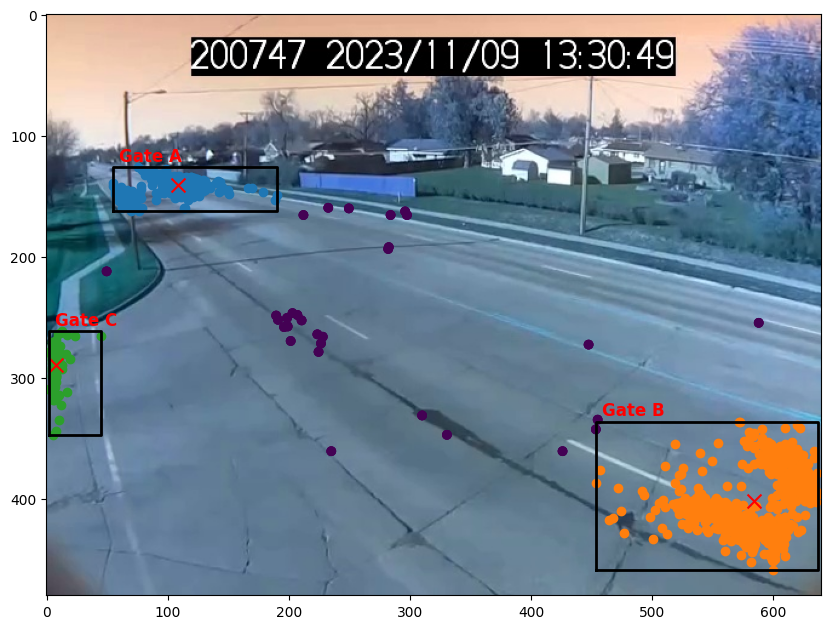

In [1037]:
# Copy df_first to avoid modifying the original during iteration
# # Define the OutGate mapping dictionary
# out_gate_mapping = {0: 'W', 1: 'E', 2: 'S', 3: 'E', 4: 'S'}

df_last_clusters = df_last.copy()

# Store updated clusters
updated_clusters = []
fig, ax = plt.subplots(figsize=(10, 8))
for cluster_id, group in df_last_clusters.groupby('Cluster'):
    centroid = (round(float(group['Center_X'].mean()),2), round(float(group['Center_Y'].mean())))
    cluster_count = len(group)
    print(cluster_id, ":", centroid, ":", cluster_count)
    
    # Find the extreme points
    x_min = group.loc[group['Center_X'].idxmin(), 'Center_X']  # Leftmost point
    x_max = group.loc[group['Center_X'].idxmax(), 'Center_X']  # Rightmost point
    y_min = group.loc[group['Center_Y'].idxmin(), 'Center_Y']  # Bottommost point
    y_max = group.loc[group['Center_Y'].idxmax(), 'Center_Y']  # Topmost point


    # Identify outliers that are outside the cluster boundary
    outliers_outside_boundary = df_outlier_last[
        (df_outlier_last['Center_X'] < x_min) | (df_outlier_last['Center_X'] > x_max) |
        (df_outlier_last['Center_Y'] < y_min) | (df_outlier_last['Center_Y'] > y_max)
    ]
    

    # Define rectangle boundary
    rectangle_corners = np.array([
        [x_min, y_max],  # Top-left
        [x_max, y_max],  # Top-right
        [x_max, y_min],  # Bottom-right
        [x_min, y_min],  # Bottom-left
        [x_min, y_max]   # Close the rectangle
    ])

    # Plot the rectangle
    plt.plot(rectangle_corners[:, 0], rectangle_corners[:, 1], 'k-', linewidth=2)

    plt.scatter(df_outlier_last['Center_X'], df_outlier_last['Center_Y'], c = df_outlier_last['Cluster'])

    # Get InGate value using the cluster_id
    out_gate = cluster_to_gate.get(cluster_id, 'Unknown')  # Default to 'Unknown' if cluster_id not in the mapping

    # Append updated cluster data
    updated_clusters.append({
        'OutClusterId': cluster_id,
        'OutGate': out_gate,  # Added InGate value
        'Centroid': centroid,
        'Boundary': (x_min, x_max, y_min, y_max)
    })

    # Plot cluster points
    plt.scatter(group['Center_X'], group['Center_Y'], label=f'Cluster {cluster_id}')

    # Plot gate name near the cluster boundary (placing near top-right corner)
    plt.text(x_min + 5, y_min - 5, f'{out_gate}', fontsize=12, color='red', fontweight='bold')

    # Plot centroid
    plt.scatter(centroid[0], centroid[1], color='red', marker='x', s=100, label=f'Centroid {cluster_id}')

    ax.imshow(cv2.imread(image_path))

OutGateClusters = pd.DataFrame(updated_clusters).sort_values('OutClusterId').reset_index(drop=True)
print(OutGateClusters)




In [1038]:
df_first_clusters = df_first_clusters.rename(columns={'Cluster':'InCluster'})
df_last_clusters = df_last_clusters.rename(columns={'Cluster':'OutCluster'})
print(df_first_clusters.head(2))
df_first_last = df_first_clusters[['vehicle_id','InCluster','InGate']].merge(df_last_clusters[['vehicle_id','OutCluster','OutGate']],on='vehicle_id',how='outer')
print(df_first_last.nunique())

   index  frame  vehicle_id       vehicle_type  Center_X  Center_Y  \
0      0      3           1  cl2_passenger_car      19.5     320.5   
1     71     73           2  cl2_passenger_car      81.0     161.5   

   Center_X_norm  Center_Y_norm  InCluster  InGate  
0      -0.924849       1.362890          4  Gate 1  
1      -0.679559      -0.668281          0  Gate 2  
vehicle_id    1222
InCluster        5
InGate           5
OutCluster       3
OutGate          3
dtype: int64


In [1039]:
print(df_first_last[df_first_last['InCluster'].isnull()].shape)
print(df_first_last[df_first_last['OutCluster'].isnull()].shape)
print(df_first_last[(df_first_last['OutCluster'].isnull())&(df_first_last['InCluster'].isnull())].shape)
print(df_first_last[(df_first_last['OutCluster'].notnull())&(df_first_last['InCluster'].notnull())].shape)

(21, 5)
(30, 5)
(0, 5)
(1171, 5)


In [1040]:
# df_ingate_null = df_first_last[df_first_last['InCluster'].isnull()].merge(df_first_frame[['vehicle_id','Center_X','Center_Y']],on='vehicle_id',how='left')

# # Convert centroids to NumPy array
# centroids = np.array([cluster.Centroid for cluster in InGateClusters.itertuples()])
# df_points = df_ingate_null[['Center_X', 'Center_Y']].values

# # Find closest centroid index and distance
# indices, distances = pairwise_distances_argmin_min(df_points, centroids)

# # Assign the closest cluster and distance
# df_ingate_null['InCluster'] = [InGateClusters.iloc[i].InClusterId for i in indices]
# df_ingate_null['InGate'] = [InGateClusters.iloc[i].InGate for i in indices]
# df_ingate_null['Min_Distance'] = distances

df_first_last = df_first_last.merge(df_first_frame[['vehicle_id', 'Center_X', 'Center_Y']], 
                                        on='vehicle_id', how='left')

# Identify rows where InCluster is null
mask = df_first_last['InCluster'].isnull()
# Convert centroids to NumPy array
centroids = np.array([cluster.Centroid for cluster in InGateClusters.itertuples()])
df_points = df_first_last.loc[mask, ['Center_X', 'Center_Y']].values

if len(df_points) > 0:
    # Find closest centroid index and distance
    indices, distances = pairwise_distances_argmin_min(df_points, centroids)
    
    # Update df_first_last in place
    df_first_last.loc[mask, 'InCluster'] = [InGateClusters.iloc[i].InClusterId for i in indices]
    df_first_last.loc[mask, 'InGate'] = [InGateClusters.iloc[i].InGate for i in indices]
    # df_first_last.loc[mask, 'Min_Distance'] = distances
    # Drop 'Center_X' and 'Center_Y' after updating
    df_first_last.drop(columns=['Center_X', 'Center_Y'], inplace=True, errors='ignore')
    print(df_first_last[mask])

    # Print only the rows that were updated
    ingate_updated_rows = df_first_last.loc[mask]
    print(ingate_updated_rows.shape)

else:
    print("No rows to update.")


      vehicle_id  InCluster  InGate  OutCluster OutGate
19            31        1.0  Gate 3         0.0  Gate A
72           111        2.0  Gate 4         2.0  Gate C
108          167        1.0  Gate 3         0.0  Gate A
119          191        0.0  Gate 2         0.0  Gate A
121          193        0.0  Gate 2         0.0  Gate A
222          376        2.0  Gate 4         2.0  Gate C
338          569        0.0  Gate 2         0.0  Gate A
339          570        4.0  Gate 1         0.0  Gate A
454          759        0.0  Gate 2         0.0  Gate A
560          922        0.0  Gate 2         0.0  Gate A
628         1046        1.0  Gate 3         0.0  Gate A
655         1094        0.0  Gate 2         0.0  Gate A
703         1166        1.0  Gate 3         0.0  Gate A
705         1170        1.0  Gate 3         0.0  Gate A
707         1174        1.0  Gate 3         0.0  Gate A
809         1350        0.0  Gate 2         1.0  Gate B
893         1485        0.0  Gate 2         0.0 

In [1041]:
# df_ingate_null = df_ingate_null.merge(
#     OutGateClusters[['OutClusterId', 'OutGate']], 
#     how='left', 
#     left_on='OutCluster', 
#     right_on='OutClusterId'
# )

# # Merge with InGateClusters to get InGate
# df_ingate_null = df_ingate_null.merge(
#     InGateClusters[['InClusterId', 'InGate']], 
#     how='left', 
#     left_on='InCluster', 
#     right_on='InClusterId'
# )

# Display the updated df_ingate_null dataframe
print((ingate_updated_rows[['InCluster','InGate','OutCluster','OutGate']].value_counts().reset_index()))
# print((df_ingate_null[(df_ingate_null['InCluster'] == 2) & (df_ingate_null['OutCluster'] == 2)][['InCluster','OutCluster','Center_X','Center_Y']]))

   InCluster  InGate  OutCluster OutGate  count
0        0.0  Gate 2         0.0  Gate A      8
1        1.0  Gate 3         0.0  Gate A      6
2        2.0  Gate 4         2.0  Gate C      4
3        0.0  Gate 2         1.0  Gate B      1
4        1.0  Gate 3         2.0  Gate C      1
5        4.0  Gate 1         0.0  Gate A      1


C:\Users\ancha\AppData\Local\Temp\ipykernel_20624\1676100427.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))


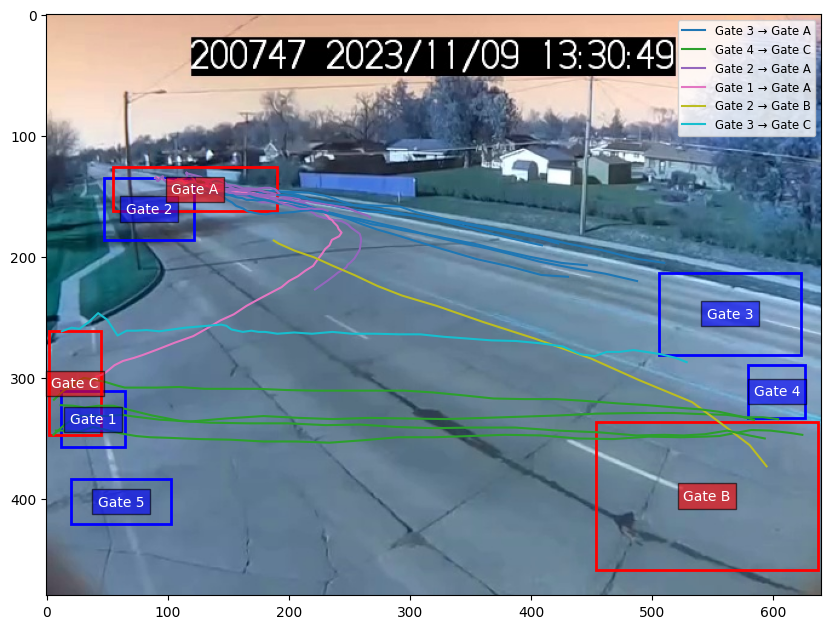

In [1042]:
# Initialize a dictionary to store legend handles
legend_handles = {}
# Merge df_ingate_null with InGateClusters to get OutGate

df = df_sorted.merge(ingate_updated_rows[['vehicle_id','InCluster','OutCluster','InGate','OutGate']],on='vehicle_id',how='inner')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(cv2.imread(image_path))
# Get unique ('InGate', 'OutGate') pairs
unique_clusters = df[['InGate', 'OutGate']].drop_duplicates()
unique_clusters = [tuple(x) for x in unique_clusters.to_numpy()]  # Convert to list of tuples

# Create a colormap
cmap = cm.get_cmap('tab10', len(unique_clusters))

# Create a mapping from ('InGate', 'OutGate') to a color
color_mapping = {cluster_pair: cmap(i / len(unique_clusters)) for i, cluster_pair in enumerate(unique_clusters)}



# # Plot InGate locations with labels
# for _, row in InGateClusters.iterrows():
#     centroid_x, centroid_y = row['Centroid']
#     ax.scatter(centroid_x, centroid_y, color='blue', marker='o', s=100, label=row['InGate'])
#     ax.text(centroid_x, centroid_y, row['InGate'], fontsize=10, ha='center', va='center', color='white', bbox=dict(facecolor='blue', alpha=0.6, edgecolor='black'))

# # Plot OutGate locations with labels
# for _, row in OutGateClusters.iterrows():
#     centroid_x, centroid_y = row['Centroid']
#     ax.scatter(centroid_x, centroid_y, color='red', marker='o', s=100, label=row['OutGate'])
#     ax.text(centroid_x, centroid_y, row['OutGate'], fontsize=10, ha='center', va='center', color='white', bbox=dict(facecolor='red', alpha=0.6, edgecolor='black'))

# Plot InGate bounding boxes with labels
for _, row in InGateClusters.iterrows():
    x_min, x_max, y_min, y_max = row['Boundary']
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='blue', facecolor='none')
    ax.add_patch(rect)
    ax.text((x_min + x_max) / 2, (y_min + y_max) / 2, row['InGate'], fontsize=10, ha='center', va='center', 
            color='white', bbox=dict(facecolor='blue', alpha=0.6, edgecolor='black'))

# Plot OutGate bounding boxes with labels
for _, row in OutGateClusters.iterrows():
    x_min, x_max, y_min, y_max = row['Boundary']
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text((x_min + x_max) / 2, (y_min + y_max) / 2, row['OutGate'], fontsize=10, ha='center', va='center', 
            color='white', bbox=dict(facecolor='red', alpha=0.6, edgecolor='black'))
    

# Group data by 'vehicle_id' and plot trajectory lines
for vehicle_id, group in df.groupby('vehicle_id'):
    # Extract the unique ('InGate', 'OutGate') pair for this vehicle
    cluster_pair = (group['InGate'].iloc[0], group['OutGate'].iloc[0])

    # Get the corresponding color
    color = color_mapping.get(cluster_pair, 'black')  # Default to black if not found

    ax.plot(group['Center_X'], group['Center_Y'], color = color, label=f'{cluster_pair[0]} → {cluster_pair[1]}')
    # Store legend entry only once per unique cluster pair
    if cluster_pair not in legend_handles:
        legend_handles[cluster_pair] = mlines.Line2D([], [], color=color, label=f'{cluster_pair[0]} → {cluster_pair[1]}')

# Add legend with correct color mapping
ax.legend(handles=legend_handles.values(), loc='best', fontsize='small', markerscale=0.5)

# Optional: Add legend to show cluster pairs
# ax.legend([f'Cluster {pair[0]} → {pair[1]}' for pair in unique_clusters], loc='best', fontsize='small', markerscale=0.5)


In [1043]:
df_first_last = df_first_last.merge(df_last_frame[['vehicle_id', 'Center_X', 'Center_Y']], 
                                        on='vehicle_id', how='left')

# Identify rows where OutCluster is null
mask = df_first_last['OutCluster'].isnull()
# Convert centroids to NumPy array
centroids = np.array([cluster.Centroid for cluster in OutGateClusters.itertuples()])
df_points = df_first_last.loc[mask, ['Center_X', 'Center_Y']].values

if len(df_points) > 0:
    # Find closest centroid index and distance
    indices, distances = pairwise_distances_argmin_min(df_points, centroids)
    
    # Update df_first_last in place
    df_first_last.loc[mask, 'OutCluster'] = [InGateClusters.iloc[i].InClusterId for i in indices]
    df_first_last.loc[mask, 'OutGate'] = [InGateClusters.iloc[i].InGate for i in indices]
    # df_first_last.loc[mask, 'Min_Distance'] = distances
    # Drop 'Center_X' and 'Center_Y' after updating
    df_first_last.drop(columns=['Center_X', 'Center_Y'], inplace=True, errors='ignore')
    # print(df_first_last[mask])
    # Print only the rows that were updated
    outgate_updated_rows = df_first_last.loc[mask]
    # print(outgate_updated_rows.shape)

else:
    print("No rows to update.")



In [1044]:
# df_outgate_null = df_outgate_null.merge(
#     OutGateClusters[['OutClusterId', 'OutGate']], 
#     how='left', 
#     left_on='OutCluster', 
#     right_on='OutClusterId'
# )

# # Merge with InGateClusters to get InGate
# df_outgate_null = df_outgate_null.merge(
#     InGateClusters[['InClusterId', 'InGate']], 
#     how='left', 
#     left_on='InCluster', 
#     right_on='InClusterId'
# )

# Display the updated df_ingate_null dataframe
print((outgate_updated_rows[['InCluster','InGate','OutCluster','OutGate']].value_counts().reset_index()))
# print((df_outgate_null[(df_outgate_null['InCluster'] == 2) & (df_outgate_null['OutCluster'] == 2)][['InCluster','OutCluster','Center_X','Center_Y']]))

   InCluster  InGate  OutCluster OutGate  count
0        0.0  Gate 2         0.0  Gate 2     14
1        1.0  Gate 3         0.0  Gate 2      6
2        0.0  Gate 2         1.0  Gate 3      5
3        4.0  Gate 1         0.0  Gate 2      2
4        2.0  Gate 4         2.0  Gate 4      1
5        3.0  Gate 5         2.0  Gate 4      1
6        4.0  Gate 1         1.0  Gate 3      1


C:\Users\ancha\AppData\Local\Temp\ipykernel_20624\3997213023.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))


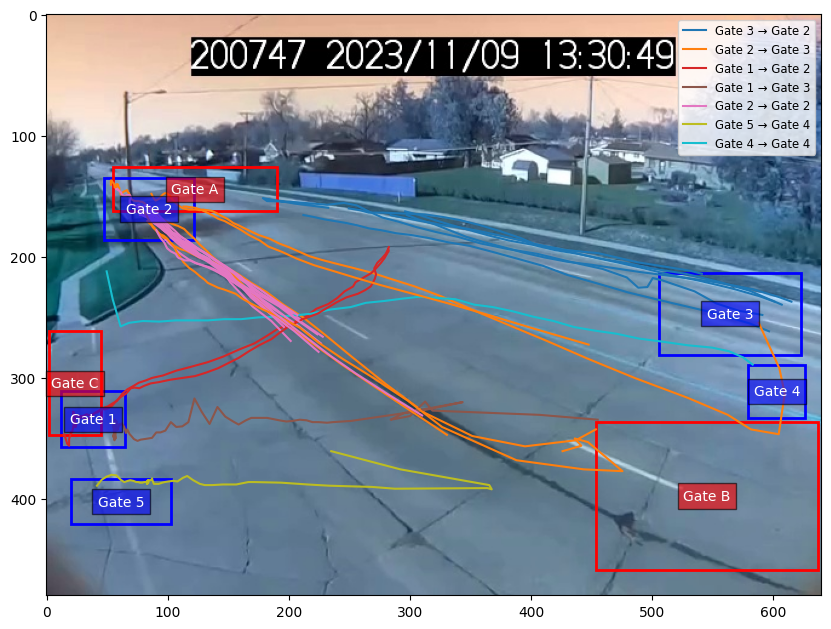

In [1045]:
import matplotlib.lines as mlines

# Initialize a dictionary to store legend handles
legend_handles = {}
# Merge df_outgate_null with OutGateClusters to get OutGate


df = df_sorted.merge(outgate_updated_rows[['vehicle_id','InCluster','OutCluster','InGate','OutGate']],on='vehicle_id',how='inner')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(cv2.imread(image_path))
# Get unique ('InGate', 'OutGate') pairs
unique_clusters = df[['InGate', 'OutGate']].drop_duplicates()
unique_clusters = [tuple(x) for x in unique_clusters.to_numpy()]  # Convert to list of tuples

# Create a colormap
cmap = cm.get_cmap('tab10', len(unique_clusters))

# Create a mapping from ('InGate', 'OutGate') to a color
color_mapping = {cluster_pair: cmap(i / len(unique_clusters)) for i, cluster_pair in enumerate(unique_clusters)}


# Plot InGate bounding boxes with labels
for _, row in InGateClusters.iterrows():
    x_min, x_max, y_min, y_max = row['Boundary']
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='blue', facecolor='none')
    ax.add_patch(rect)
    ax.text((x_min + x_max) / 2, (y_min + y_max) / 2, row['InGate'], fontsize=10, ha='center', va='center', 
            color='white', bbox=dict(facecolor='blue', alpha=0.6, edgecolor='black'))

# Plot OutGate bounding boxes with labels
for _, row in OutGateClusters.iterrows():
    x_min, x_max, y_min, y_max = row['Boundary']
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text((x_min + x_max) / 2, (y_min + y_max) / 2, row['OutGate'], fontsize=10, ha='center', va='center', 
            color='white', bbox=dict(facecolor='red', alpha=0.6, edgecolor='black'))
    
# Group data by 'vehicle_id' and plot trajectory lines
for vehicle_id, group in df.groupby('vehicle_id'):
    # Extract the unique ('InGate', 'OutGate') pair for this vehicle
    cluster_pair = (group['InGate'].iloc[0], group['OutGate'].iloc[0])

    # Get the corresponding color
    color = color_mapping.get(cluster_pair, 'black')  # Default to black if not found

    ax.plot(group['Center_X'], group['Center_Y'], color = color, label=f'{cluster_pair[0]} → {cluster_pair[1]}')
    # Store legend entry only once per unique cluster pair
    if cluster_pair not in legend_handles:
        legend_handles[cluster_pair] = mlines.Line2D([], [], color=color, label=f'{cluster_pair[0]} → {cluster_pair[1]}')

# Add legend with correct color mapping
ax.legend(handles=legend_handles.values(), loc='best', fontsize='small', markerscale=0.5)

# Optional: Add legend to show cluster pairs
# ax.legend([f'Cluster {pair[0]} → {pair[1]}' for pair in unique_clusters], loc='best', fontsize='small', markerscale=0.5)


In [1046]:
# merges each vehicle's first frame cluster ID into df_sorted, ensuring consistent cluster IDs for all vehicle occurrences.
final_df = df_sorted.merge(df_first_last[['vehicle_id','InCluster','InGate','OutCluster','OutGate']],on='vehicle_id',how='inner')

print(final_df)

       frame  vehicle_id               vehicle_type  Center_X  Center_Y  \
0          3           1          cl2_passenger_car      19.5     320.5   
1          4           1          cl2_passenger_car      25.5     322.0   
2          5           1          cl2_passenger_car      33.0     320.5   
3          6           1          cl2_passenger_car      39.5     316.0   
4          7           1  cl3_four_tire_single_unit      44.5     316.5   
...      ...         ...                        ...       ...       ...   
68375  35981        2019          cl2_passenger_car     468.0     391.0   
68376  35982        2019          cl2_passenger_car     515.0     401.5   
68377  35983        2019          cl2_passenger_car     545.0     417.0   
68378  35984        2019          cl2_passenger_car     580.5     431.0   
68379  35985        2019          cl2_passenger_car     601.5     438.5   

       InCluster  InGate  OutCluster OutGate  
0            4.0  Gate 1         0.0  Gate A  
1    

In [1047]:
# Store results
vehicle_data_result = []

for vehicle_id, vehicle_traj_group in final_df.groupby('vehicle_id'):
        
    # Store result
    vehicle_data_result.append({
        'Vehicle ID': vehicle_id, 
        'Class': vehicle_traj_group.iloc[0]['vehicle_type'],
        'Start Frame': vehicle_traj_group.iloc[0]['frame'],
        'End Frame': vehicle_traj_group.iloc[-1]['frame'],
        'InCluster': vehicle_traj_group.iloc[0]['InCluster'],
        'InGate': vehicle_traj_group.iloc[0]['InGate'],
        'OutCluster': vehicle_traj_group.iloc[0]['OutCluster'],
        'OutGate': vehicle_traj_group.iloc[0]['OutGate']
        })
        

# Convert to DataFrame if needed
output = pd.DataFrame(vehicle_data_result).sort_values(by='Vehicle ID').reset_index(drop=True)
print(output.shape)

(1222, 8)


In [1048]:
output['Counted'] = np.where(output['InGate'] == output['OutGate'], '', 'Y')
new_column_order = ['Vehicle ID','Class','Start Frame','End Frame','Counted','InCluster','InGate','OutCluster','OutGate']
output = output[new_column_order]
print(output.shape)
output.to_csv("../output_test.csv",index=False)

(1222, 9)
